**Problem 1:** *Capacitated facility location.* 

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the attached script to generate the data, and to visualize the results. You are supposed to play with different configurations and sizes of the problem. Please make your report detailed (otherwise lower amount of points then indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.
* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.
* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

Below is the solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code. 

In [2]:
from gurobipy import *

import numpy as np
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
import copy as copy

%matplotlib inline

np.random.seed(1)

C = 20; # number of clients
clients = np.random.rand(2,C); #client positions
F = 15; #number of facilities
facilities = np.random.rand(2,F);

capacities = np.ones((F,))*4; #maximum number of clients per facility

dx = np.matlib.repmat(clients[0,:],F,1) - np.matlib.repmat(facilities[0,:],C,1).transpose();
dy = np.matlib.repmat(clients[1,:],F,1) - np.matlib.repmat(facilities[1,:],C,1).transpose();

assignment_costs = 3*(dx*dx + dy*dy); #the assignment cost is the distance squared

opening_costs = np.ones((F,));

# create the model
m = Model("facility")

y = []
for i_f in range(F):
    y.append(m.addVar(vtype=GRB.BINARY))

x = []    
for i_f in range(F):
    x.append([])
    for i_c in range(C):
        x[i_f].append(m.addVar(vtype=GRB.BINARY))

# the objective is to minimize the total fixed and variable costs
m.modelSense = GRB.MINIMIZE

# update model to integrate new variables
m.update()

# set optimization objective - minimize sum of fixed costs
obj_summands = []
for i_f in range(F):
    obj_summands.append(opening_costs[i_f]*y[i_f])
    
for i_f in range(F):
    for i_c in range(C):
        obj_summands.append(assignment_costs[i_f][i_c]*x[i_f][i_c])

m.setObjective(quicksum(obj_summands))  

# set constraints
for i_c in range(C):
    client_constr_summands = [x[i_f][i_c] for i_f in range(F)]
    m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)
        
for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(sum(facility_constr_summands), GRB.LESS_EQUAL, capacities[i_f]*y[i_f])       

for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(max(facility_constr_summands), GRB.LESS_EQUAL, y[i_f])     

# optimize
  
m.optimize()

# plot the solution
facilities_opened = [y[i_f].X for i_f in range(F)]    
clients_assignment = [i_f for i_f in range(F) for i_c in range(C) if x[i_f][i_c].X != 0]

print clients_assignment

plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment)
plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened])
plt.show()


GurobiError: Failed to connect to token server 'SRV-EDUAPP-01' (port 41954) - license file 'C:\Users\Evgeny\Documents\gurobi.lic'.  Consult the Quick Start Guide for instructions on starting a token server.

## Greedy algorithm

In [ ]:
# if j facility is closed then fac_is_open[j] = 0, else - fac_is_open[j] = 1
fac_is_open = [0] * F

# number of clients at each facility
num_clients = [0] * F

final_greedy_distribution = np.zeros((F, C))

final_cost = 0
proposed_costs = np.zeros(F)
for i in range(C):
    for j in range(F):
        
        # Generating all variants for the client i
        if num_clients[j] < 4:
            proposed_costs[j] = opening_costs[j] * (fac_is_open[j] ^ 1) + assignment_costs[j][i]
        
        else:
            proposed_costs[j] = np.inf
    
    # Find the best variant
    best_variant = np.argmin(proposed_costs)
    
    num_clients[best_variant] += 1
    # print i, best_variant
    fac_is_open[best_variant] = fac_is_open[best_variant] or 1
    final_cost += proposed_costs[best_variant]
    final_greedy_distribution[best_variant][i] = int(1)
print 'Cost =', final_cost
print 'Clients distribution =', num_clients


facilities_opened_greedy = fac_is_open
clients_assignment_greedy = [i_f for i_f in range(F) for i_c in range(C) if final_greedy_distribution[i_f][i_c] != 0]

plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment_greedy)
plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened_greedy])
plt.show()

In [ ]:
# Generating random client-facility situation

distr = np.zeros((F,C))
for i in range(C):
    distr[(i) % F][i] = 1
    
plt.spy(distr)

## Local optimization algorithm

In [4]:
def neighborhood(distr):
    neighborhood =  []
    for i in range(C):
        for j in range(F):
            current_facility = np.argmax(distr[:, i])
            if j != current_facility:
                if distr[j].sum() < 4:
                    neighbor_distr = copy.copy(distr)
                    neighbor_distr[j][i] = 1
                    neighbor_distr[current_facility][i] = 0
                    neighborhood.append(neighbor_distr)
                if distr[j].sum() == 4:
                    neighbor_distr = copy.copy(distr)
                    partner = np.argsort(-distr[j])[np.random.randint(4)]
                    neighbor_distr[j][i], neighbor_distr[j][partner] = 1, 0
                    neighbor_distr[current_facility][i], neighbor_distr[current_facility][partner] = 0,  1 
                    neighborhood.append(neighbor_distr)
    return neighborhood

In [5]:
def cost(distr, assignment_costs=assignment_costs, opening_costs=opening_costs):
    fac_is_open = [0] * F
    for i in range(F):
        if distr[i].sum() != 0:
            fac_is_open[i] = 1
    cost = np.trace(assignment_costs.T.dot(distr)) + opening_costs.T.dot(fac_is_open)
    return cost

In [6]:
def local_opt(distr):
    is_min = False
    current_vertex = distr
    while is_min == False:
        adj_costs = []
        current_cost = cost(current_vertex)
        
        U = neighborhood(current_vertex)
        
        for adj_vertex in U:
            adj_costs.append(cost(adj_vertex))
        
        opt_adj_vertex = np.argmin(adj_costs)
        # print 'хуйня', adj_costs[opt_adj_vertex]
        if current_cost < adj_costs[opt_adj_vertex]:
            is_min = True
        else:
            current_vertex = U[opt_adj_vertex]
        print 'cost =', current_cost        
    return current_vertex, current_cost

cost = 36.4467270541
cost = 33.0843632951
cost = 29.919519015
cost = 27.0674945826
cost = 24.4903709988
cost = 22.3573435306
cost = 19.726232462
cost = 17.9832844588
cost = 16.2804127314
cost = 14.6181705316
cost = 13.0403127068
cost = 11.4631379501
cost = 10.1715777643
cost = 9.84487678382
cost = 9.52466536747
cost = 9.33955590578
cost = 9.20062566276
cost = 9.10593524559
cost = 9.06294513599


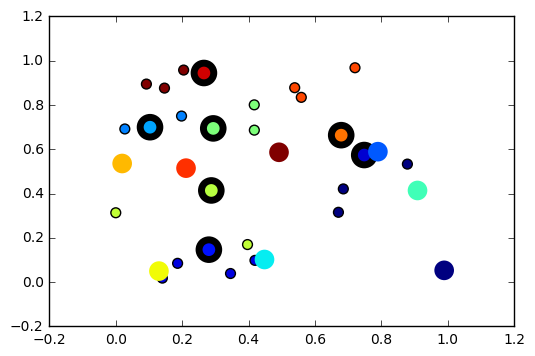

In [8]:
local_opt_result, local_opt_result_cost = local_opt(distr)


facilities_opened_local_opt = [0] * F
for j in range(F):
    if local_opt_result[j].sum() != 0:
        facilities_opened_local_opt[j] = 1

# print local_opt_result.sum(axis=1)
        
clients_assignment_local_opt = [0] * C
for i in range(C):
    current_facility = np.argmax(local_opt_result[:, i])
    clients_assignment_local_opt[i] = current_facility

plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment_local_opt)
plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened_local_opt])
plt.show()


## Simulated annealing algorithm

In [9]:
def get_random_neighbour(distr):
    
    U = neighborhood(distr) # [house[:] for house in state]
    random_number = np.random.randint(0, len(U))
    
    return U[random_number]

In [10]:
def simulated_annealing(initial, num_iter):
    
    current = initial
    best = initial
    current_cost = cost(current)
    # initial temp value
    temp = 10.0 
    iteration = 0
    cost_history = []
    cost_history.append(current_cost)
    
    while iteration <= num_iter: 
        
        # finding random adjacent vertex(neighbour)
        neighbour = get_random_neighbour(current)
        neighbour_cost = cost(neighbour)

        # difference between neighbour and current costs
        cost_delta = neighbour_cost - current_cost
        iteration += 1
                  
        if cost_delta <= 0 or random.random() < np.exp(-cost_delta / temp):
            current, current_cost = neighbour, neighbour_cost
            cost_history.append(current_cost)
            
        if current_cost < cost(best):
                best = current
        
        # changing the temperature
        temp = 0.5 * temp
        
    return best, cost_history

C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: overflow encountered in exp
C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars


cost = 9.06294513599


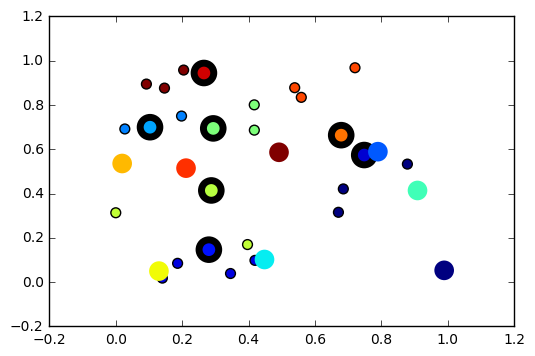

In [11]:
solution, history= simulated_annealing(local_opt_result, 10000)
print 'cost =', cost(solution)

facilities_opened_sa = [0] * F
for j in range(F):
    if solution[j].sum() != 0:
        facilities_opened_sa[j] = 1

# print local_opt_result.sum(axis=1)
        
clients_assignment_sa = [0] * C
for i in range(C):
    current_facility = np.argmax(solution[:, i])
    clients_assignment_sa[i] = current_facility

plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment_sa)
plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened_sa])
plt.show()

In [12]:
history

[9.0629451359938429,
 9.2576874632763939,
 10.789801638605773,
 9.8956673374931601,
 9.7009250102106073,
 9.0629451359938429]

** Problem 2 **: *Optimal vehicle speed scheduling (6 points) *-- (based on an additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of *n* segments, between *n + 1* waypoints labeled *0, . . . , n*. Segment *i* starts at waypoint *i − 1* and terminates at waypoint *i*. The vehicle starts at time *t = 0* at waypoint *0*. It travels over each segment at a constant (nonnegative) speed; *si* is the speed on segment *i*. We have lower and upper limits on the speeds: *smin ≤ s ≤ smax*. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment *i* is *di* (which is positive), so the travel time over segment *i* is *di/si*. We let *τi*, *i = 1, . . . , n,* denote the time at which the vehicle arrives at waypoint *i*. The vehicle is required to arrive at waypoint *i*, *for i = 1, . . . , n*, between times *τmin,i* and *τmax,i* , which are given. The vehicle consumes fuel over segment *i* at a rate that depends on its speed *Φ(s_i )=a s_i^2+b s_i+c kg/s*.

You are given the data *d* (segment travel distances), *smin* and *smax* (speed bounds), *τmin* and *τmax* (waypoint arrival time bounds), and the the parameters *a*, *b*, and *c* (all parameters are in *veh_speed_sched_data.m*). Use the dynamic programming approach to find the schedule that allows spending the minimal amount of fuel. Use matplotlib command *step* to plot speed vs time for the optimal schedule. You will need to discretize some continuous variables, make sure you do it densely enough. **NB**: later in the course we will get back to this problem and attack it with a different method.


In [4]:
import scipy.io as sio
from cvxpy import *
import cvxpy as cvx
import numpy as np

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a']
b = mat_contents['b']
c = mat_contents['c']
d = mat_contents['d']
n = mat_contents['n']
smin = mat_contents['smin']
smax = mat_contents['smax']
tau_min = mat_contents['tau_min']
tau_max = mat_contents['tau_max']

a, b, c, n = a[0][0], b[0][0], c[0][0], n[0][0]

In [5]:
def nan_to_inf(x):
    (n, m) = x.shape
    x = np.nan_to_num(x)
    for i in range(n):
        for j in range(m):
            if x[i][j] == 0:
                x[i][j] = np.inf
    return x

In [25]:
k = 100

# Time discretization
time_discr  = np.zeros((n, k))
for i in range(n):
    for j in range(k):
        eps = (tau_max[i][0] - tau_min[i][0]) / k
        time_discr[i][j] = tau_min[i][0] + (j + 0.5) * eps

prev_fuel = np.zeros(k)
path = []


for i in range(n):
    
    # dtime - all differencies between discret time on i-th segment and (i-1)-th segment
    if i == 0:
        dtime = np.array([time_discr[i]] * k).T
    else:
        dtime = np.array([np.maximum(0, time_discr[i][j] - time_discr[i-1]) for j in range(k)])
    
    # calculating speed for all variants
    speed = d[i][0] / dtime
    speed = np.where(speed >= smin[i], speed, np.inf)
    speed = np.where(speed <= smax[i], speed, np.inf)
    # print speed
    
    # calculating fuel for dtime
    current_fuel = (a * speed ** 2 + b * speed + c) * dtime
    # nan deleting
    current_fuel = nan_to_inf(current_fuel)
    print current_fuel
    # calculating new fuel 
    
    # print current_fuel
    
    current_fuel = current_fuel + prev_fuel
    prev_fuel = np.min(current_fuel, axis=1)
    path.append(np.argmin(current_fuel, axis=1))
    # print prev_fuel
    # print 'nnnnnn\n'
    fuel = prev_fuel

# printing minimal variant
print 'cost =', min(fuel), np.argmin(fuel)

[[  2.61492709e+001   2.61492709e+001   2.61492709e+001 ...,
    2.61492709e+001   2.61492709e+001   2.61492709e+001]
 [  2.63974891e+001   2.63974891e+001   2.63974891e+001 ...,
    2.63974891e+001   2.63974891e+001   2.63974891e+001]
 [  2.66523598e+001   2.66523598e+001   2.66523598e+001 ...,
    2.66523598e+001   2.66523598e+001   2.66523598e+001]
 ..., 
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
    1.79769313e+308   1.79769313e+308   1.79769313e+308]
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
    1.79769313e+308   1.79769313e+308   1.79769313e+308]
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
    1.79769313e+308   1.79769313e+308   1.79769313e+308]]
[[  2.47738159e+001   2.44370335e+001   2.41011765e+001 ...,
                inf               inf               inf]
 [  2.51319382e+001   2.47942385e+001   2.44574020e+001 ...,
                inf               inf               inf]
 [  2.54909709e+001   2.51524145e+001   2.481466

C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: divide by zero encountered in divide
C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in multiply
C:\Users\Evgeny\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: overflow encountered in add


[[  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
                inf               inf               inf]
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
                inf               inf               inf]
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
                inf               inf               inf]
 ..., 
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
    1.79769313e+308   1.79769313e+308   1.79769313e+308]
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
    1.79769313e+308   1.79769313e+308   1.79769313e+308]
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
    1.79769313e+308   1.79769313e+308   1.79769313e+308]]
[[  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
                inf               inf               inf]
 [  1.79769313e+308   1.79769313e+308   1.79769313e+308 ...,
                inf               inf               inf]
 [  1.79769313e+308   1.79769313e+308   1.797693

In [23]:
np.array([time_discr[0]] * k).T

array([[ 1.0987595,  1.0987595,  1.0987595, ...,  1.0987595,  1.0987595,
         1.0987595],
       [ 1.1344785,  1.1344785,  1.1344785, ...,  1.1344785,  1.1344785,
         1.1344785],
       [ 1.1701975,  1.1701975,  1.1701975, ...,  1.1701975,  1.1701975,
         1.1701975],
       ..., 
       [ 4.5635025,  4.5635025,  4.5635025, ...,  4.5635025,  4.5635025,
         4.5635025],
       [ 4.5992215,  4.5992215,  4.5992215, ...,  4.5992215,  4.5992215,
         4.5992215],
       [ 4.6349405,  4.6349405,  4.6349405, ...,  4.6349405,  4.6349405,
         4.6349405]])

In [83]:
index = n - 1
best = 0
time = []
while index != -1:
    time.append(time_discr[index][best])
    best = path[index][best]
    index -= 1

In [84]:
time.append(0)
time.reverse()

In [85]:
fuel = 0
speed = []
for i in range(1, 101):
    dt = time[i] - time[i-1]
    s = d[i-1] / dt
    speed.append(s)
    fuel += (a * s ** 2 + b * s + c) * dt

speed = np.array(speed)
fuel = fuel[0]

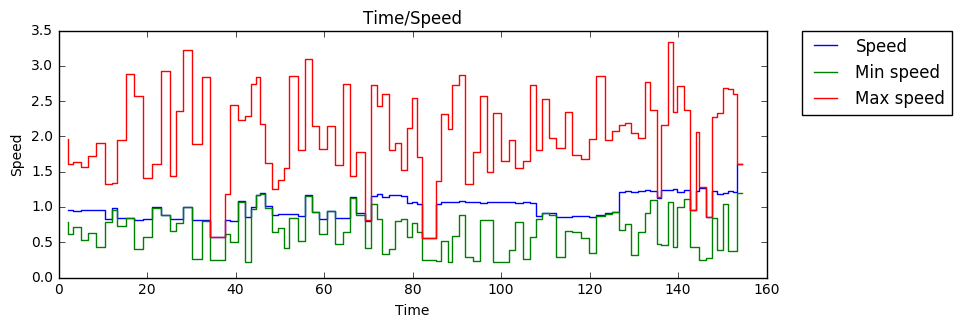

In [86]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))

speedplot = fig.add_subplot(2,1,1)
speedplot.step(time[1:], speed, label='Speed')
speedplot.step(time[1:], smin, label='Min speed')
speedplot.step(time[1:], smax, label='Max speed')
speedplot.set_title('Time/Speed')
speedplot.set_xlabel('Time')
speedplot.set_ylabel('Speed')
speedplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

plt.show()

In [72]:
time_discr[0]

array([ 1.19996333,  1.43809   ,  1.67621667,  1.91434333,  2.15247   ,
        2.39059667,  2.62872333,  2.86685   ,  3.10497667,  3.34310333,
        3.58123   ,  3.81935667,  4.05748333,  4.29561   ,  4.53373667])

In [73]:
print tau_min[0], tau_max[0]

[ 1.0809] [ 4.6528]
